In [20]:
import pandas as pd 
import numpy as np
import mlflow 

from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns


In [24]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")
mlflow.search_experiments()

tracking URI: 'file:///Users/xiahe/Documents/OnlineCourse/mlops-final-project/mlruns'


[<Experiment: artifact_location='file:///Users/xiahe/Documents/OnlineCourse/mlops-final-project/mlruns/0', creation_time=1690709860714, experiment_id='0', last_update_time=1690709860714, lifecycle_stage='active', name='Default', tags={}>]

In [2]:
df = pd.read_csv("data/bbc_news.csv.zip", compression='zip')
df.head()

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


In [4]:
df.shape

(19445, 5)

In [3]:
df.isnull().sum()

title          0
pubDate        0
guid           0
link           0
description    0
dtype: int64

In [5]:
df['news'] = df['title'] + ' ' + df['description']

In [8]:
# Sentence Transformers pip install -U sentence-transformers
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

df['news_embedding'] = model.encode(df['news'], convert_to_tensor=True).tolist()

In [9]:
# Save the embeddings to disk 
df.to_csv('data/news_embedding.csv', index=False, sep='\t')

In [15]:
def cal_input_matrix(df):
    embdding = df.loc[:, 'news_embedding'].apply(np.array) # .apply(eval).Convert string to numpy array
    matrix = np.vstack(embdding.values)
    return matrix
    
    
def convert_to_tsne(matrix, n_components=2, perplexity=15, random_state=42, init='random', lr=200):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state,
                init=init, learning_rate=lr)
    vis_dims2 = tsne.fit_transform(matrix)
    # x = [x for x, y in vis_dims2]
    # y = [y for x, y in vis_dims2]
    df = pd.DataFrame(vis_dims2, columns=['tsne_1', 'tsne_2'])
    return df


In [16]:
# Prepare input data
matrix = cal_input_matrix(df)
df_tsne = convert_to_tsne(matrix)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
mlflow.set_experiment('my-experiment-1')

with mlflow.start_run():
    # Train KMeans model 
    params = {'n_clusters': 20,  'init': 'k-means++', 'random_state': 42}
    mlflow.log_params(params)

    kmeans = KMeans(**params)
    kmeans.fit(matrix)
    labels = kmeans.labels_

    mlflow.sklearn.log_model(kmeans, artifact_path='models')
    print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")
# Save the model


2023/07/30 11:42:50 INFO mlflow.tracking.fluent: Experiment with name 'my-experiment-1' does not exist. Creating a new experiment.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/xiahe/.local/share/virtualenvs/mlops-final-project-70huLeJa/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
default artifacts URI: 'file:///Users/xiahe/Documents/OnlineCourse/mlops-final-project/mlruns/448113044398298761/0876f19c877540e48d45dd6221d36864/artifacts'


/Users/xiahe/.local/share/virtualenvs/mlops-final-project-70huLeJa/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [26]:
mlflow.search_experiments()

[<Experiment: artifact_location='file:///Users/xiahe/Documents/OnlineCourse/mlops-final-project/mlruns/448113044398298761', creation_time=1690710170174, experiment_id='448113044398298761', last_update_time=1690710170174, lifecycle_stage='active', name='my-experiment-1', tags={}>,
 <Experiment: artifact_location='file:///Users/xiahe/Documents/OnlineCourse/mlops-final-project/mlruns/0', creation_time=1690709860714, experiment_id='0', last_update_time=1690709860714, lifecycle_stage='active', name='Default', tags={}>]

In [21]:
def plot_clusters(df_tsne, labels):
    p = sns.scatterplot(data=df_tsne, x='tsne_1', y='tsne_2', hue=labels, legend='full', palette='deep')
    sns.move_legend(p, 'upper right', bbox_to_anchor = (1.17, 1.), title='Clusters')
    plt.title('Clusters of BBC news')
    plt.show

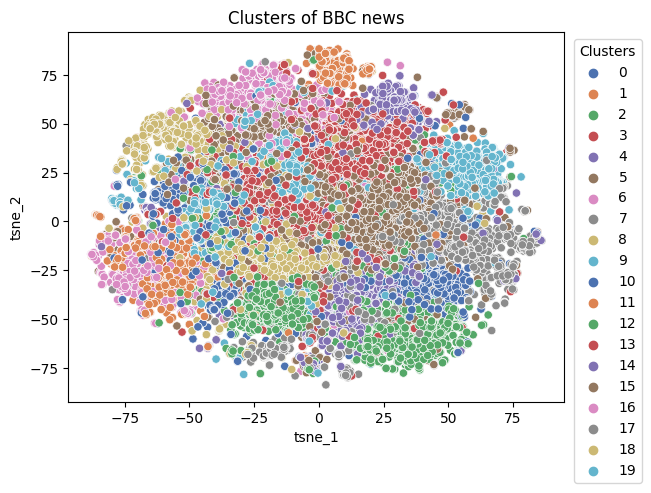

In [22]:
plot_clusters(df_tsne, labels)

#### Interact with Model registry

In [27]:
from mlflow.tracking import MlflowClient


client = MlflowClient("http://127.0.0.1:5000")

In [28]:
client.search_registered_models()  #list

[<RegisteredModel: aliases={}, creation_timestamp=1690710614949, description='', last_updated_timestamp=1690710614972, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1690710614972, current_stage='None', description='', last_updated_timestamp=1690710614972, name='kmeans-20', run_id='0876f19c877540e48d45dd6221d36864', run_link='', source='file:///Users/xiahe/Documents/OnlineCourse/mlops-final-project/mlruns/448113044398298761/0876f19c877540e48d45dd6221d36864/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='1'>], name='kmeans-20', tags={}>]